# Modeling

This notebook contains all steps taken in the modeling phase of the data science pipeline for the Superstore Time Series project. This notebook does rely on helper files so if you want to run the code blocks in this notebook ensure that you have all the helper files in the same directory.

---

## The Required Imports

Everything we need to run the code blocks in this notebook are imported below. To run the code blocks in this report you will need numpy, pandas, matplotlib, seaborn and sklearn installed on your computer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from prophet import Prophet

from sklearn.metrics import mean_squared_error

# from prepare import split_data
from wrangle import wrangle
from prepare import split_data
from evaluate import *

Importing plotly failed. Interactive plots will not work.


---

## Acquire, Prepare, and Split the Data

Here we will acquire and prepare the data using the wrangle module. We'll then split each dataframe into train, validate, and test using the prepare module.

In [2]:
superstore, store_east, store_west, store_south, store_central, office_supplies, furniture, technology = wrangle()

Reading from .csv file.


In [3]:
superstore_train, superstore_validate, superstore_test = split_data(superstore)

store_east_train, store_east_validate, store_east_test = split_data(store_east)
store_west_train, store_west_validate, store_west_test = split_data(store_west)
store_south_train, store_south_validate, store_south_test = split_data(store_south)
store_central_train, store_central_validate, store_central_test = split_data(store_central)

office_supplies_train, office_supplies_validate, office_supplies_test = split_data(office_supplies)
furniture_train, furniture_validate, furniture_test = split_data(furniture)
technology_train, technology_validate, technology_test = split_data(technology)

---

## Establishing a Baseline

Now we need to establish a baseline against which to compare the performance of our models. We'll use various simple forecasting strategies (last observed value, simple average, various moving averages) and pick the strategy with the lowest RMSE value to be our baseline.

### Last Observed Value

We'll start by creating a last observed value forecast.

In [4]:
# Calculate the last observed value.

last_observed_value = round(superstore_train.sales[-1], 2)
last_observed_value

4987.26

In [5]:
# Create a dataframe of predictions using the last observed value.

predictions = make_static_predictions('sales', last_observed_value, superstore_validate.index)
predictions.head()

,sales
order_date,
2016-01-03,4987.26
2016-01-10,4987.26
2016-01-17,4987.26
2016-01-24,4987.26
2016-01-31,4987.26


In [6]:
# Add the results to the eval_df.

eval_df = append_eval_df('Last Observed Value', 'sales', superstore_validate, predictions)
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,3598.0


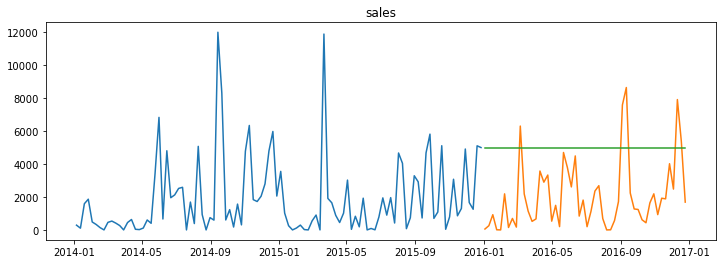

In [7]:
# Visualize the results.

plot_forecast('sales', superstore_train, superstore_validate, predictions)

### Simple Average

Now let's create a simple average forecast.

In [8]:
# Calculate the simple average.

simple_avg = round(superstore_train.sales.mean(), 2)
simple_avg

1861.29

In [9]:
# Create a predictions dataframe using the simple average.

predictions = make_static_predictions('sales', simple_avg, superstore_validate.index)
predictions.head()

,sales
order_date,
2016-01-03,1861.29
2016-01-10,1861.29
2016-01-17,1861.29
2016-01-24,1861.29
2016-01-31,1861.29


In [10]:
# Add the results to eval_df.

eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,3598.0
1,Simple Average,sales,2089.0


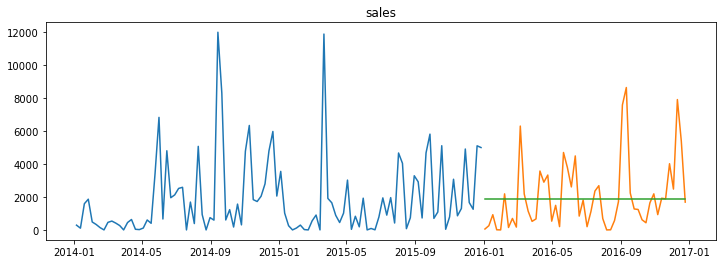

In [11]:
# Visualize the results.

plot_forecast('sales', superstore_train, superstore_validate, predictions)

### Moving Average

Now we'll create various moving average forecasts. We'll do the following moving averages: 1 month, 1 quarter, half year, and full year.

In [12]:
# Our data is grouped by weeks so we will use values 4, 12, 26, and 52.
periods = [4, 12, 26, 52]

# For each period:
# - Calculate the moving average
# - Create the predictions dataframe
# - Add the results to eval_df
for period in periods:
    moving_avg = round(superstore_train.sales.rolling(period).mean()[-1], 2)
    predictions = make_static_predictions('sales', moving_avg, superstore_validate.index)
    eval_df = append_eval_df(f'Moving Average {period} Weeks', 'sales', superstore_validate, predictions, eval_df)
    
eval_df

,model_type,target,rmse
0,Last Observed Value,sales,3598.0
1,Simple Average,sales,2089.0
2,Moving Average 4 Weeks,sales,2399.0
3,Moving Average 12 Weeks,sales,2130.0
4,Moving Average 26 Weeks,sales,2112.0
5,Moving Average 52 Weeks,sales,2094.0


### Results

For the overall total sales the simple average forecast provides the lowest RMSE value so this will be the baseline. We can determine this programmatically as well.

In [13]:
# Get the row with the minimum rmse value.

eval_df[eval_df.rmse == eval_df.rmse.min()]

,model_type,target,rmse
1,Simple Average,sales,2089.0


### Throw it in a Function

Finally, let's create a function that can determine the best baseline for us.

In [14]:
# def establish_baseline(train, validate):
#     forecast_values = {
#         'Last Observed Value' : round(train.sales[-1], 2),
#         'Simple Average' : round(train.sales.mean(), 2)
#     }

#     periods = [4, 12, 26, 52]
#     for period in periods:
#         forecast_values[f'Moving Average {period} Weeks'] = round(train.sales.rolling(period).mean()[-1], 2)

#     predictions = {}
#     for key, value in forecast_values.items():
#         predictions[key] = make_static_predictions('sales', value, validate.index)

#     eval_df = None
#     for key, prediction in predictions.items():
#         eval_df = append_eval_df(key, 'sales', validate, prediction, eval_df)

#     return eval_df[eval_df.rmse == eval_df.rmse.min()]

In [15]:
# Let's test it

# establish_baseline(superstore_train, superstore_validate)

In [16]:
# Now let's test it from the model.py file.

from model import establish_baseline

eval_df = establish_baseline(superstore_train, superstore_validate)
eval_df

,model_type,target,rmse
1,Simple Average,sales,2089.0


---

## Creating Different Forecasting Models

Now that we have a baseline model we can try out some dynamic modeling strategies such as Holt's Linear Trend and FB Prophet.

### Holt's Linear Trend

Here we'll create a Holt model for forecasting sales.

In [17]:
# Create the model

model = Holt(superstore_train.sales, damped_trend = True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [18]:
# Fit the model

model = model.fit()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [19]:
# Make predictions

predictions = model.predict(
    start = superstore_validate.index[0],
    end = superstore_validate.index[-1]
)
predictions.head()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2016-01-03    3187.481390
2016-01-10    3270.026987
2016-01-17    3351.714971
2016-01-24    3432.554254
2016-01-31    3512.553653
Freq: W-SUN, dtype: float64

In [20]:
# Make predictions a dataframe

predictions = pd.DataFrame(predictions, columns = ['sales'], index = predictions.index)
predictions.head()

,sales
2016-01-03,3187.481390
2016-01-10,3270.026987
2016-01-17,3351.714971
2016-01-24,3432.554254
2016-01-31,3512.553653


In [21]:
eval_df = append_eval_df('Holt', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,sales,2089.0
1,Holt,sales,3544.0


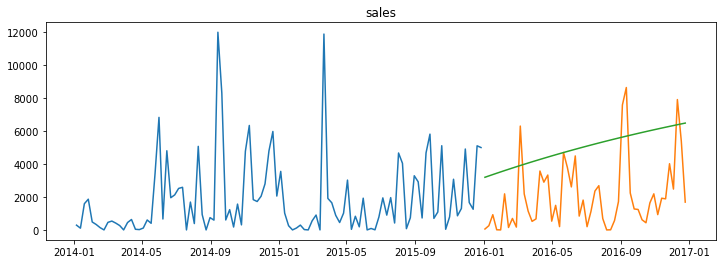

In [22]:
plot_forecast('sales', superstore_train, superstore_validate, predictions)

This model performs far worse than the baseline.

### FB Prophet

Now let's try a Prophet model.

In [23]:
# Create the model

model = Prophet()

In [24]:
# Fit the model

model.fit(pd.DataFrame({
    'ds' : superstore_train.index,
    'y' : superstore_train.sales
}))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.50357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       119.538   1.06219e-07       90.2011      0.4486      0.4486      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       119.538   3.12052e-09         91.34      0.2796      0.2796      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [25]:
# Make predictions

future = model.make_future_dataframe(365)
results = model.predict(future)
predictions = results[['ds', 'yhat']].set_index('ds')
predictions.columns = ['sales']
predictions = predictions.resample('W').mean()
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2014-01-05 to 2017-01-01
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   157 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [26]:
eval_df = append_eval_df('Prophet', 'sales', superstore_validate, predictions.loc['2016'], eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,sales,2089.0
1,Holt,sales,3544.0
2,Prophet,sales,2201.0


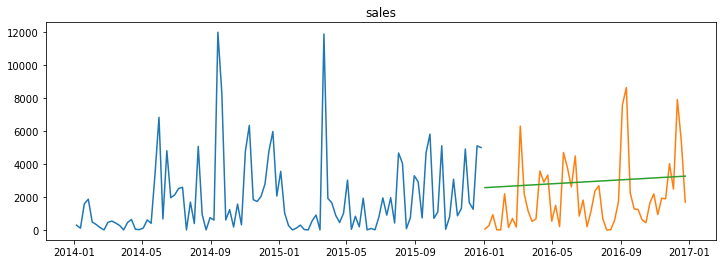

In [27]:
plot_forecast('sales', superstore_train, superstore_validate, predictions.loc['2016'])

Prophet also does not beat the baseline. We will likely need to narrow down the data by some category that will provide clearer insights into the sales trends. Without any seasonality in the data it's difficult to create an accurate model that does more than forecast average sales figures.

### Previous Cycle

Let's try one more strategy and use the previous cycle to predict the next one.

In [28]:
predictions = superstore_train.loc['2015'] + superstore_train.diff(52).mean()
predictions.index = superstore_validate.index

In [29]:
eval_df = append_eval_df('Previous Cycle', 'sales', superstore_validate, predictions, eval_df)
eval_df

,model_type,target,rmse
0,Simple Average,sales,2089.0
1,Holt,sales,3544.0
2,Prophet,sales,2201.0
3,Previous Cycle,sales,3080.0


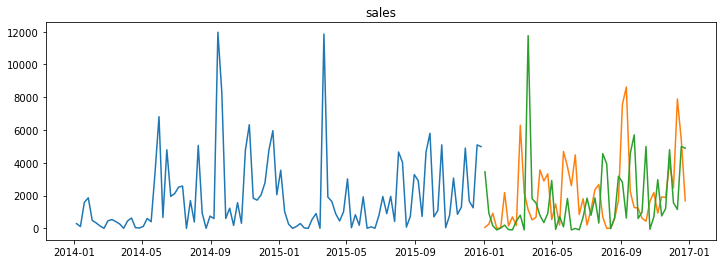

In [30]:
plot_forecast('sales', superstore_train, superstore_validate, predictions)

---

## Ensemble Model: A Model Per Region

In exploration we noticed that there is a little more seasonality when filtered by region. So here we will try to build an ensemble model where we have a sales forecast for each region and then combine the results to make a total sales forecast.

### Simple Average

Since the simple average provided the best results for the total sales model we'll create a simple average model here as well.

In [31]:
superstore_train.sales.mean()

1861.2878721153852

In [33]:
store_east_train.sales.mean() + store_west_train.sales.mean() + store_central_train.sales.mean() + store_south_train.sales.mean()

1894.2580870575055

In [34]:
east_predictions = make_static_predictions('sales', store_east_train.sales.mean(), store_east_validate.index)
west_predictions = make_static_predictions('sales', store_west_train.sales.mean(), store_west_validate.index)
central_predictions = make_static_predictions('sales', store_central_train.sales.mean(), store_central_validate.index)
south_predictions = make_static_predictions('sales', store_south_train.sales.mean(), store_south_validate.index)

predictions = east_predictions + west_predictions + central_predictions + south_predictions
predictions.head()

,sales
order_date,
2016-01-03,1894.258087
2016-01-10,1894.258087
2016-01-17,1894.258087
2016-01-24,1894.258087
2016-01-31,1894.258087


In [35]:
region_eval_df = append_eval_df('Simple Average', 'sales', superstore_validate, predictions)
region_eval_df

,model_type,target,rmse
0,Simple Average,sales,2086.0
